In [15]:
!pip install xgboost
!pip install polars
!pip install optuna
!pip install missingno
!pip install lightgbm
!pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
    --------------------------------------- 1.3/101.7 MB 16.6 MB/s eta 0:00:07
   -- ------------------------------------- 7.1/101.7 MB 25.6 MB/s eta 0:00:04
   ---- ----------------------------------- 12.6/101.7 MB 26.3 MB/s eta 0:00:04
   ------- -------------------------------- 18.9/101.7 MB 27.1 MB/s eta 0:00:04
   --------- ------------------------------ 24.6/101.7 MB 27.4 MB/s eta 0:00:03
   ------------ --------------------------- 32.0/101.7 MB 28.6 MB/s eta 0:00:03
   --------------- ------------------------ 39.3/101.7 MB 29.4 MB/s eta 0:00:03
   ------------------ --------------------- 45.9/101.7 MB 30.1 MB/s eta 0:00:02
   -------------------- ------------------- 52.7/101.7 MB 30.5 MB/s eta 0:00:02
   ----------------------- ---------------- 60.3/101.7 MB 31.0 MB/s eta 0:00:02
   --------------------------- ------------ 68.9/101.7 MB 32.1 MB/s eta 0:00:02
   ------------------------------ --------- 78.6/10

In [275]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import missingno as msno
import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 5400
n_splits = 5

In [277]:

full = pd.read_csv("C:\\Users\\mingy\\OneDrive\\Desktop\\project\\train.csv")
sample =pd.read_csv("C:\\Users\mingy\\OneDrive\\Desktop\\project\\sample_submission.csv")

full_removed = full.dropna(subset=['sii'])

full_removed['PAQ_PAQ_Total'] = full_removed['PAQ_C-PAQ_C_Total'].add(full_removed['PAQ_A-PAQ_A_Total'],fill_value=0)
# train['PAQ_PAQ_Total'].isnull().sum()/len(train['PAQ_PAQ_Total'])
# train

full_removed['Fitness_Endurance_Time']= full_removed['Fitness_Endurance-Time_Mins']*60+full_removed['Fitness_Endurance-Time_Sec']
# train['Fitness_Endurance_Time'].isnull().sum()/len(train['Fitness_Endurance_Time'])

full_removed.drop('PAQ_C-PAQ_C_Total', axis=1)
full_removed.drop('PAQ_A-PAQ_A_Total', axis=1)
full_removed.drop('Fitness_Endurance-Time_Mins', axis=1)
full_removed.drop('Fitness_Endurance-Time_Sec', axis=1)

train, test = train_test_split(full_removed, test_size=0.20, random_state=5400)

# Save or display the train and test data
output_path = r'C:\\Users\\mingy\\OneDrive\\Desktop\\project'

# Save the datasets to the specified folder
full_removed.to_csv(f'{output_path}\\full_data.csv', index=False)
train.to_csv(f'{output_path}\\train_data.csv', index=False)
test.to_csv(f'{output_path}\\test_data.csv', index=False)

In [278]:
test_id = test['id']

In [281]:
train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance_Time',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_PAQ_Total', 'PAQ_C-Season',
       'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday','sii']

train = train[featuresCols]
#train = train.dropna(subset='sii')


cat_c = ['Basic_Demos-Enroll_Season','CGAS-Season','Physical-Season','Fitness_Endurance-Season','FGC-Season',
 'BIA-Season','PAQ_A-Season','PAQ_C-Season','SDS-Season','PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c : 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
        
    return df

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

    
for col in cat_c:
    all_values = pd.concat([train[col], test[col]]).unique()
    mapping = {value: idx for idx, value in enumerate(all_values)}

    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mapping).astype(int)

In [283]:
train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance_Time,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_PAQ_Total,PAQ_C-Season,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
257,0,19,1,0,55.0,0,30.795216,61.00,163.0,NaN,78.0,84.0,121.0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,4.88039,30.7986,1439.190,2158.79,34.77900,95.5561,18.0552,12.74340,67.44390,2.0,37.7007,23.0764,90.6757,44.7690,72.4797,0,NaN,0,0,NaN,NaN,0,3.0,2.0
2049,1,8,1,1,71.0,1,17.256269,50.50,62.6,NaN,76.0,73.0,111.0,1,5.0,530.0,1,2.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,13.5,1.0,14.0,1.0,9.0,1.0,1,3.0,11.30980,17.2582,1003.940,1606.30,12.77070,49.1957,13.5627,3.69541,13.40430,2.0,21.6434,14.7816,37.8860,19.5208,34.4142,0,NaN,0,1,27.0,40.0,1,NaN,0.0
782,1,8,1,0,70.0,2,14.403180,52.00,55.4,NaN,77.0,89.0,114.0,0,NaN,NaN,2,15.0,1.0,NaN,NaN,NaN,NaN,7.0,1.0,11.0,1.0,13.0,1.0,10.0,1.0,2,3.0,2.66328,14.4048,1011.340,1618.14,11.18040,49.9839,12.9965,1.40826,5.41609,2.0,21.5658,17.2377,47.3206,23.1641,32.7462,0,2.370,1,2,53.0,73.0,1,0.0,0.0
144,2,8,0,2,61.0,1,14.706858,48.00,48.2,NaN,78.0,91.0,111.0,1,6.0,600.0,1,7.0,1.0,NaN,NaN,NaN,NaN,3.0,0.0,11.0,1.0,11.0,1.0,4.0,0.0,1,4.0,13.53960,14.7085,948.830,1992.54,4.96490,43.3258,13.2211,1.48737,4.87416,2.0,21.1448,17.2161,29.7863,18.5188,26.1097,0,NaN,0,1,32.0,46.0,2,2.0,1.0
2602,2,9,0,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,3,43.0,60.0,2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,3,13,1,2,55.0,4,19.440988,67.50,126.0,NaN,67.0,66.0,111.0,0,NaN,NaN,3,22.0,1.0,17.0,2.0,18.8,2.0,2.0,0.0,9.0,0.0,9.0,0.0,10.0,1.0,4,4.0,5.43437,19.3856,1372.040,2606.87,29.46230,88.4030,13.6012,5.78445,37.59700,1.0,33.6762,25.2646,82.9686,38.9271,63.1384,0,2.300,4,3,32.0,46.0,3,2.0,2.0
3157,1,9,1,4,80.0,1,15.457014,47.40,49.4,NaN,54.0,71.0,119.0,1,8.0,807.0,1,10.0,1.0,NaN,NaN,NaN,NaN,10.0,1.0,12.0,1.0,11.0,1.0,7.0,1.0,1,3.0,8.90922,15.4587,948.876,1518.20,10.43070,43.3308,13.5595,1.89924,6.06923,1.0,22.0129,10.8872,34.4215,23.1713,32.4436,0,2.210,3,1,43.0,60.0,1,0.0,0.0
3502,0,5,0,2,50.0,0,18.258526,47.50,58.6,NaN,78.0,93.0,137.0,3,NaN,NaN,4,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,8.0,1.0,8.5,1.0,3.0,0.0,0,2.0,2.76433,18.2605,964.084,1542.53,9.34071,44.9506,14.0072,4.25333,13.64940,2.0,24.4984,11.1115,42.1863,18.1459,33.8391,0,NaN,0,0,NaN,NaN,0,2.0,0.0
1472,0,10,0,0,55.0,0,21.147561,53.00,84.5,NaN,55.0,77.0,108.0,0,NaN,NaN,4,2.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,6.0,0.0,5.0,0.0,2.0,0.0,0,3.0,3.08923,21.2250,1081.220,1838.08,10.45800,57.4274,14.3738,6.85120,27.37260,2.0,26.5102,20.4592,54.3382,24.0135,36.9682,0,1.781,1,4,55.0,76.0,0,3.0,2.0


In [285]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier

def fill_missing_with_lgbm(train, test, target_column, n_estimators=1000, random_state=5400):
    train = train.copy()
    test = test.copy()

    # Determine the model type
    if train[target_column].dtype == 'object' or target_column in cat_c:
        model_type = 'classification'
    else:
        model_type = 'regression'

    # Add a flag to differentiate train and test
    train['is_train'] = 1
    test['is_train'] = 0

    # Combine train and test
    df = pd.concat([train, test], ignore_index=True)

    # Identify features excluding the target column and 'is_train'
    features_columns = [col for col in df.columns if col not in [target_column, 'is_train']]

    # Drop non-numeric columns from features
    numeric_features = df[features_columns].select_dtypes(include=['number']).columns.tolist()
    features_columns = numeric_features

    # Split into rows with and without missing values
    df_missing = df[df[target_column].isnull()]
    df_not_missing = df[~df[target_column].isnull()]

    if df_missing.empty or df_not_missing.empty:
        print(f"No missing data in '{target_column}' column or all data are missing.")
        return train.drop(columns=['is_train']), test.drop(columns=['is_train'])

    # Prepare training data for LightGBM
    X_train = df_not_missing[features_columns]
    y_train = df_not_missing[target_column]

    # Prepare model
    if model_type == 'regression':
        model = LGBMRegressor(n_estimators=n_estimators, random_state=random_state)
    else:
        model = LGBMClassifier(n_estimators=n_estimators, random_state=random_state)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict missing values
    X_pred = df_missing[features_columns]
    y_pred = model.predict(X_pred)

    # Fill missing values
    df.loc[df[target_column].isnull(), target_column] = y_pred

    # Split back into train and test
    train_filled = df[df['is_train'] == 1].drop(columns=['is_train'])
    test_filled = df[df['is_train'] == 0].drop(columns=['is_train'])

    return train_filled, test_filled

# List of columns to fill
basic_cols = [
    'Basic_Demos-Age', 'Basic_Demos-Sex',
    'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'Physical-Waist_Circumference','Fitness_Endurance-Max_Stage',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
    'PAQ_PAQ_Total'
]

# Define categorical columns if necessary
cat_c = []  # Replace with a list of categorical columns, if applicable

# Loop through columns to fill missing values
for col in basic_cols:
    print(f"开始填补特征: {col}")
    train, test = fill_missing_with_lgbm(train, test, col)


开始填补特征: Basic_Demos-Age
No missing data in 'Basic_Demos-Age' column or all data are missing.
开始填补特征: Basic_Demos-Sex
No missing data in 'Basic_Demos-Sex' column or all data are missing.
开始填补特征: CGAS-CGAS_Score
开始填补特征: Physical-BMI
开始填补特征: Physical-Height
开始填补特征: Physical-Weight
开始填补特征: Physical-Waist_Circumference
开始填补特征: Fitness_Endurance-Max_Stage
开始填补特征: Physical-Diastolic_BP
开始填补特征: Physical-HeartRate
开始填补特征: Physical-Systolic_BP
开始填补特征: SDS-SDS_Total_Raw
开始填补特征: SDS-SDS_Total_T
开始填补特征: PreInt_EduHx-computerinternet_hoursday
开始填补特征: PAQ_PAQ_Total


In [286]:
train['Fitness_Endurance-Max_Stage'] = train['Fitness_Endurance-Max_Stage'].astype(int)
train['Physical-HeartRate'] = train['Physical-HeartRate'].astype(int)
test['Fitness_Endurance-Max_Stage'] = test['Fitness_Endurance-Max_Stage'].astype(int)
test['Physical-HeartRate'] = test['Physical-HeartRate'].astype(int)

In [287]:
train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance_Time,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_PAQ_Total,PAQ_C-Season,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total
0,0,19,1,0,55.000000,0,30.795216,61.00000,163.000000,37.644036,78.000000,84,121.000000,0,5,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,4.88039,30.7986,1439.190,2158.79,34.77900,95.5561,18.0552,12.74340,67.44390,2.0,37.7007,23.0764,90.6757,44.7690,72.4797,0,1.819184,0,0,53.665901,74.993778,0,3.00000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8,1,1,71.000000,1,17.256269,50.50000,62.600000,25.272548,76.000000,73,111.000000,1,5,530.0,1,2.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,13.5,1.0,14.0,1.0,9.0,1.0,1,3.0,11.30980,17.2582,1003.940,1606.30,12.77070,49.1957,13.5627,3.69541,13.40430,2.0,21.6434,14.7816,37.8860,19.5208,34.4142,0,2.089100,0,1,27.000000,40.000000,1,0.21414,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,8,1,0,70.000000,2,14.403180,52.00000,55.400000,22.179047,77.000000,89,114.000000,0,5,NaN,2,15.0,1.0,NaN,NaN,NaN,NaN,7.0,1.0,11.0,1.0,13.0,1.0,10.0,1.0,2,3.0,2.66328,14.4048,1011.340,1618.14,11.18040,49.9839,12.9965,1.40826,5.41609,2.0,21.5658,17.2377,47.3206,23.1641,32.7462,0,2.370000,1,2,53.000000,73.000000,1,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,8,0,2,61.000000,1,14.706858,48.00000,48.200000,22.867685,78.000000,91,111.000000,1,6,600.0,1,7.0,1.0,NaN,NaN,NaN,NaN,3.0,0.0,11.0,1.0,11.0,1.0,4.0,0.0,1,4.0,13.53960,14.7085,948.830,1992.54,4.96490,43.3258,13.2211,1.48737,4.87416,2.0,21.1448,17.2161,29.7863,18.5188,26.1097,0,2.465957,0,1,32.000000,46.000000,2,2.00000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,9,0,3,65.597766,3,16.039530,49.87781,29.751736,20.866233,57.648469,76,106.706013,0,8,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.447426,0,3,43.000000,60.000000,2,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,3,13,1,2,55.000000,4,19.440988,67.50000,126.000000,28.727221,67.000000,66,111.000000,0,4,NaN,3,22.0,1.0,17.0,2.0,18.8,2.0,2.0,0.0,9.0,0.0,9.0,0.0,10.0,1.0,4,4.0,5.43437,19.3856,1372.040,2606.87,29.46230,88.4030,13.6012,5.78445,37.59700,1.0,

In [288]:
FGC_cols = [
  'FGC-FGC_CU',
  'FGC-FGC_CU_Zone',
  'FGC-FGC_GSND',
  'FGC-FGC_GSND_Zone',
  'FGC-FGC_GSD',
  'FGC-FGC_GSD_Zone',
  'FGC-FGC_PU',
  'FGC-FGC_PU_Zone',
  'FGC-FGC_SRL',
  'FGC-FGC_SRL_Zone',
  'FGC-FGC_SRR',
  'FGC-FGC_SRR_Zone',
  'FGC-FGC_TL',
  'FGC-FGC_TL_Zone'
]
for col in FGC_cols:
    print("开始填补特征："+ col)
    train, test = fill_missing_with_lgbm(train, test, col)

开始填补特征：FGC-FGC_CU
开始填补特征：FGC-FGC_CU_Zone
开始填补特征：FGC-FGC_GSND
开始填补特征：FGC-FGC_GSND_Zone
开始填补特征：FGC-FGC_GSD
开始填补特征：FGC-FGC_GSD_Zone
开始填补特征：FGC-FGC_PU
开始填补特征：FGC-FGC_PU_Zone
开始填补特征：FGC-FGC_SRL
开始填补特征：FGC-FGC_SRL_Zone
开始填补特征：FGC-FGC_SRR
开始填补特征：FGC-FGC_SRR_Zone
开始填补特征：FGC-FGC_TL
开始填补特征：FGC-FGC_TL_Zone


In [289]:
train['FGC-FGC_CU_Zone']=train['FGC-FGC_CU_Zone'].astype(int)
train['FGC-FGC_GSND_Zone']=train['FGC-FGC_GSND_Zone'].astype(int)
train['FGC-FGC_GSD_Zone']=train['FGC-FGC_GSD_Zone'].astype(int)
train['FGC-FGC_SRL_Zone']=train['FGC-FGC_SRL_Zone'].astype(int)
train['FGC-FGC_SRR_Zone']=train['FGC-FGC_SRR_Zone'].astype(int)
train['FGC-FGC_TL_Zone']=train['FGC-FGC_TL_Zone'].astype(int)


test['FGC-FGC_CU_Zone']=test['FGC-FGC_CU_Zone'].astype(int)
test['FGC-FGC_GSND_Zone']=test['FGC-FGC_GSND_Zone'].astype(int)
test['FGC-FGC_GSD_Zone']=test['FGC-FGC_GSD_Zone'].astype(int)
test['FGC-FGC_SRL_Zone']=test['FGC-FGC_SRL_Zone'].astype(int)
test['FGC-FGC_SRR_Zone']=test['FGC-FGC_SRR_Zone'].astype(int)
test['FGC-FGC_TL_Zone']=test['FGC-FGC_TL_Zone'].astype(int)

In [290]:
train['BIA-Season'] = train['BIA-Season'].fillna('Other')
test['BIA-Season'] = test['BIA-Season'].fillna('Other')

# if only use BIA variables, still have missing, using Phsical- variables help
BIA = ['Basic_Demos-Age', 'Basic_Demos-Sex',
    'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'Physical-Waist_Circumference','Fitness_Endurance-Max_Stage',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
    'PAQ_PAQ_Total',
       'BIA-Season',
       "BIA-BIA_TBW","BIA-BIA_TBW","BIA-BIA_DEE","BIA-BIA_BMC","BIA-BIA_Fat", "BIA-BIA_BMI",'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM']
for col in BIA:
    print("开始填补特征："+ col)
    train, test = fill_missing_with_lgbm(train, test, col)

开始填补特征：Basic_Demos-Age
No missing data in 'Basic_Demos-Age' column or all data are missing.
开始填补特征：Basic_Demos-Sex
No missing data in 'Basic_Demos-Sex' column or all data are missing.
开始填补特征：CGAS-CGAS_Score
No missing data in 'CGAS-CGAS_Score' column or all data are missing.
开始填补特征：Physical-BMI
No missing data in 'Physical-BMI' column or all data are missing.
开始填补特征：Physical-Height
No missing data in 'Physical-Height' column or all data are missing.
开始填补特征：Physical-Weight
No missing data in 'Physical-Weight' column or all data are missing.
开始填补特征：Physical-Waist_Circumference
No missing data in 'Physical-Waist_Circumference' column or all data are missing.
开始填补特征：Fitness_Endurance-Max_Stage
No missing data in 'Fitness_Endurance-Max_Stage' column or all data are missing.
开始填补特征：Physical-Diastolic_BP
No missing data in 'Physical-Diastolic_BP' column or all data are missing.
开始填补特征：Physical-HeartRate
No missing data in 'Physical-HeartRate' column or all data are missing.
开始填补特征：Physical-Sy

In [291]:
train = update(train)
test = update(test)

In [292]:
train.to_csv(f'{output_path}\\train_clean.csv', index=False)
test.to_csv(f'{output_path}\\test_clean.csv', index=False)

<Axes: >

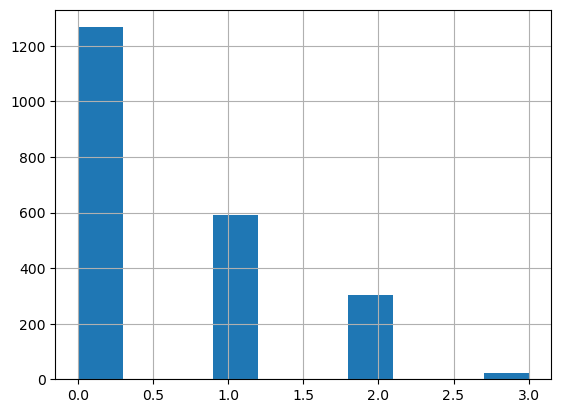

In [293]:
train["sii"].hist()

<Axes: >

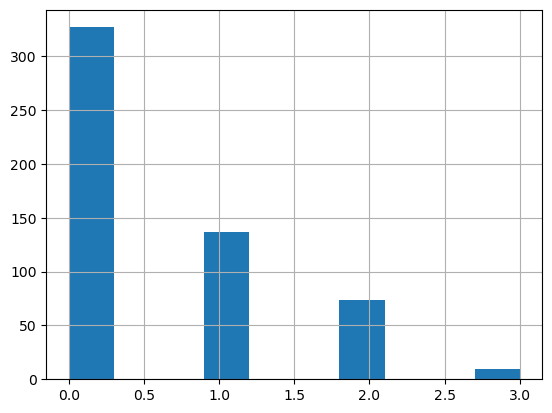

In [294]:
test["sii"].hist()

In [295]:
missing_percent_train = train.isnull().mean() * 100
missing_percent_train

Basic_Demos-Enroll_Season      0.0
Basic_Demos-Age                0.0
Basic_Demos-Sex                0.0
CGAS-Season                    0.0
CGAS-CGAS_Score                0.0
                             ...  
PCIAT-PCIAT_17               100.0
PCIAT-PCIAT_18               100.0
PCIAT-PCIAT_19               100.0
PCIAT-PCIAT_20               100.0
PCIAT-PCIAT_Total            100.0
Length: 83, dtype: float64

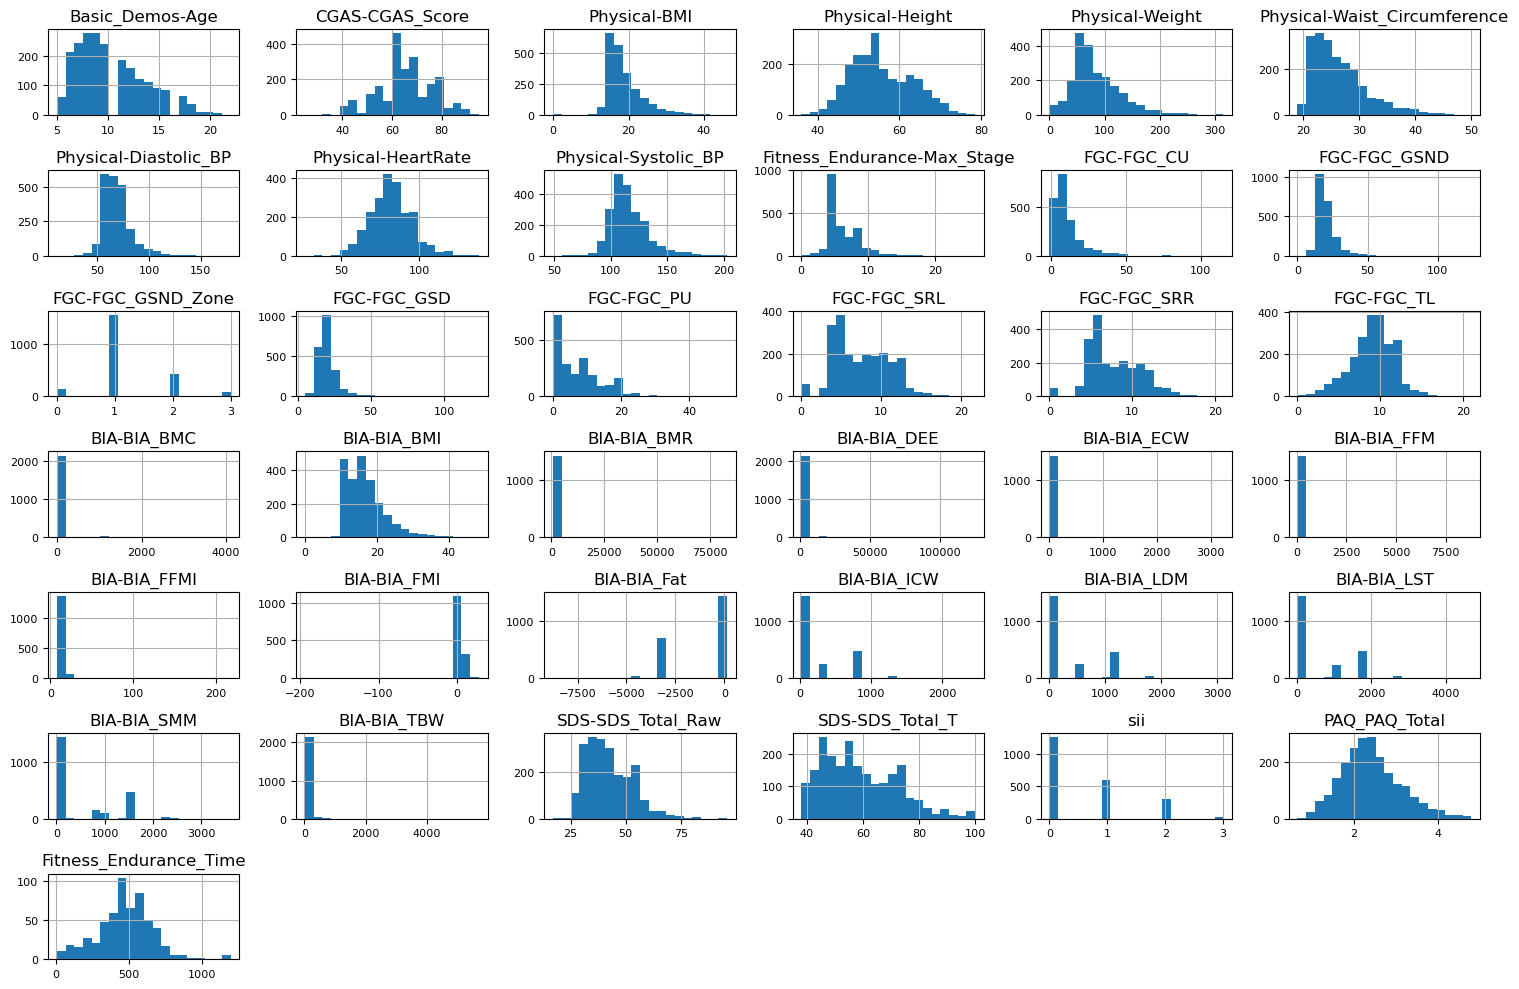

In [345]:
histcols = ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage',
       'FGC-FGC_CU',  'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_PU',
       'FGC-FGC_SRL',  'FGC-FGC_SRR',
        'FGC-FGC_TL', 
        'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW',  
        'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 
        'sii', 'PAQ_PAQ_Total', 'Fitness_Endurance_Time']

train[histcols].hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

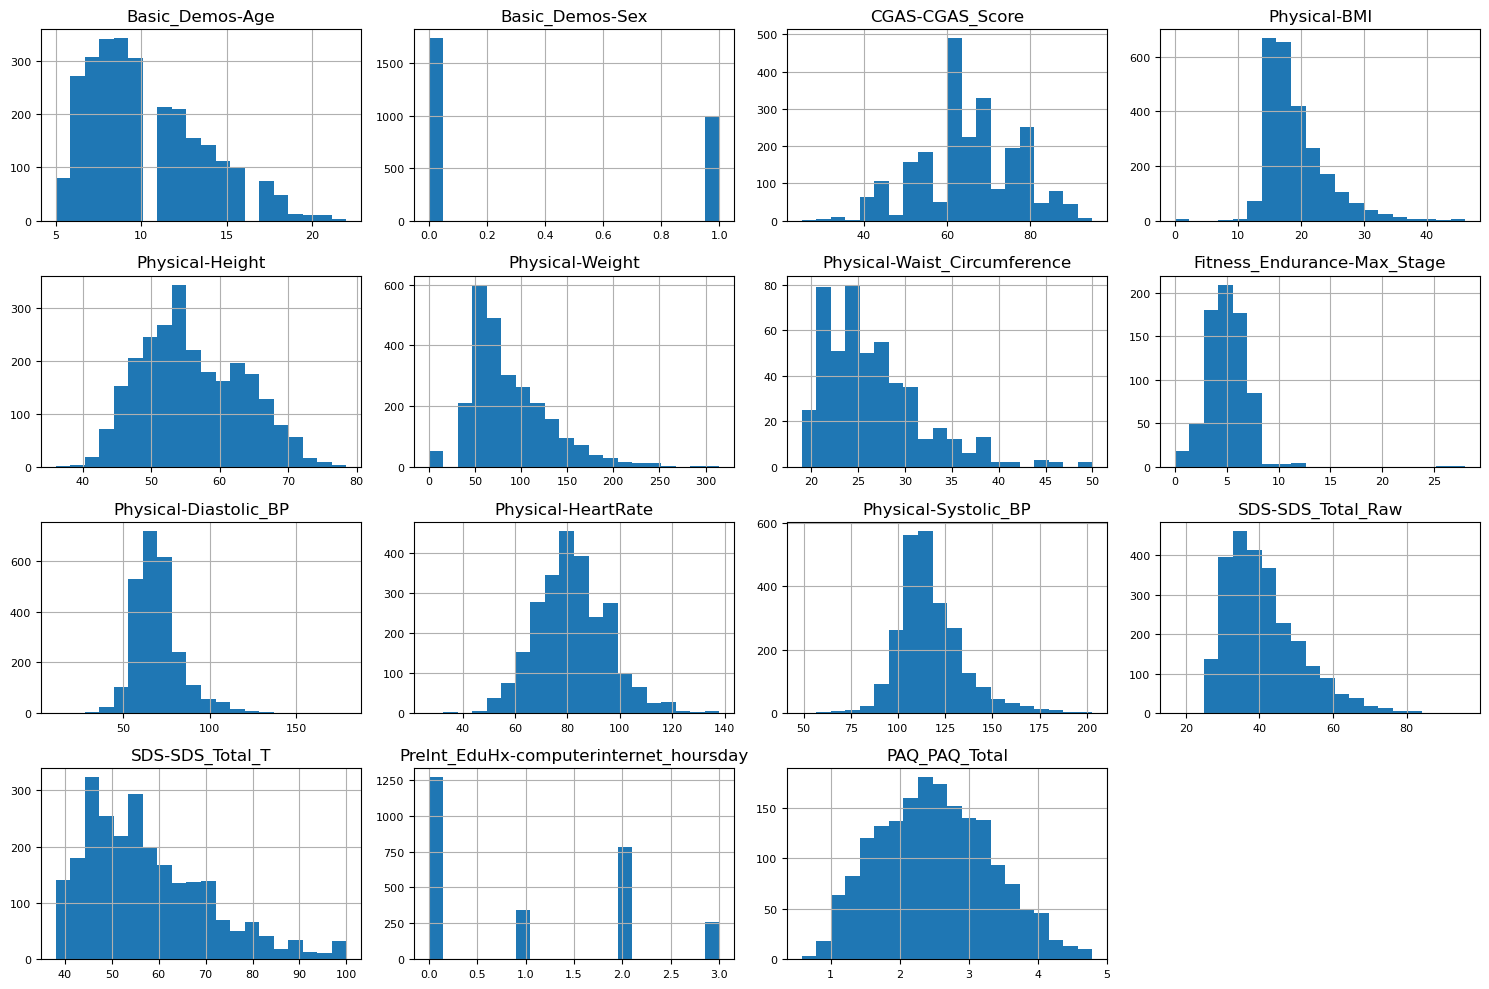

In [349]:
# basic info variable hist capare
full_removed[basic_cols].hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

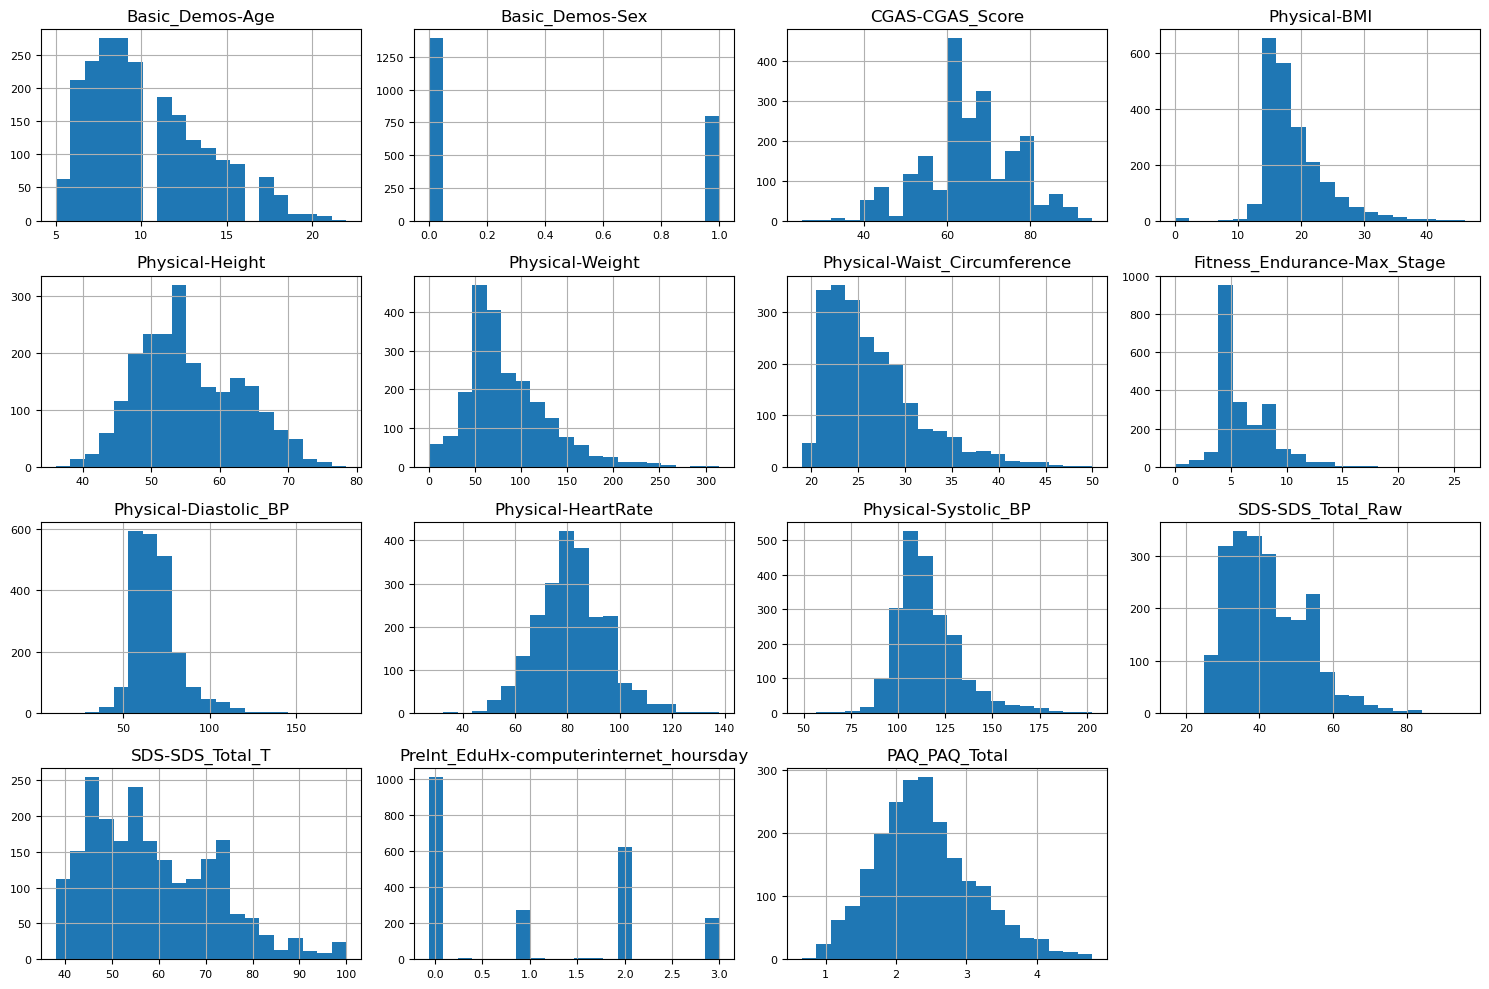

In [347]:
train[basic_cols].hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

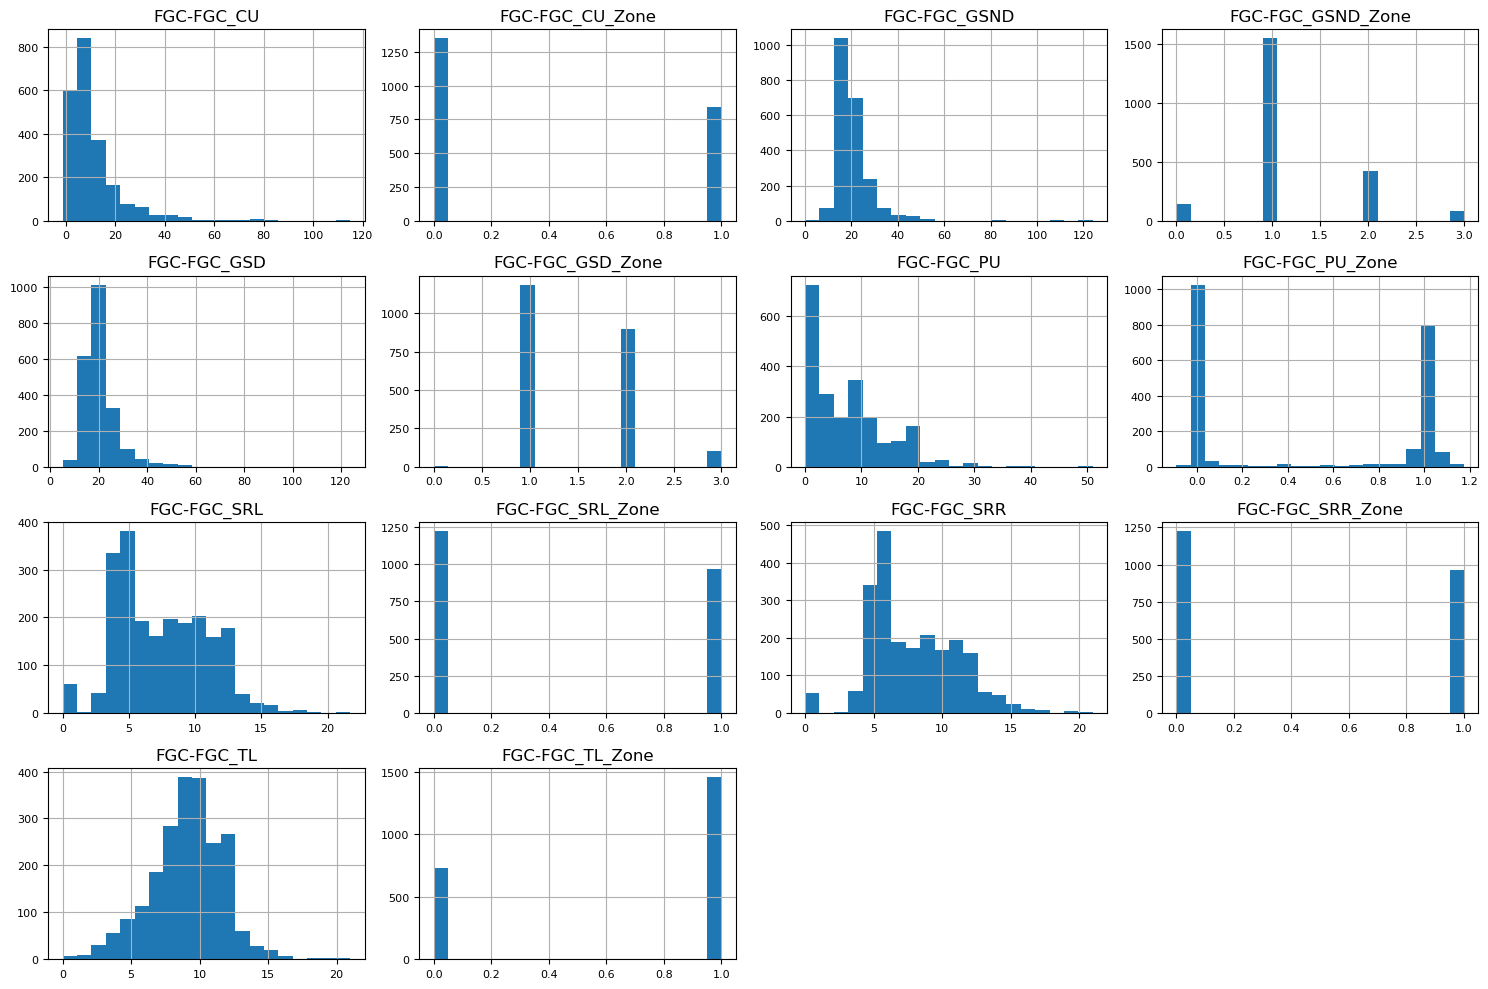

In [351]:
train[FGC_cols].hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

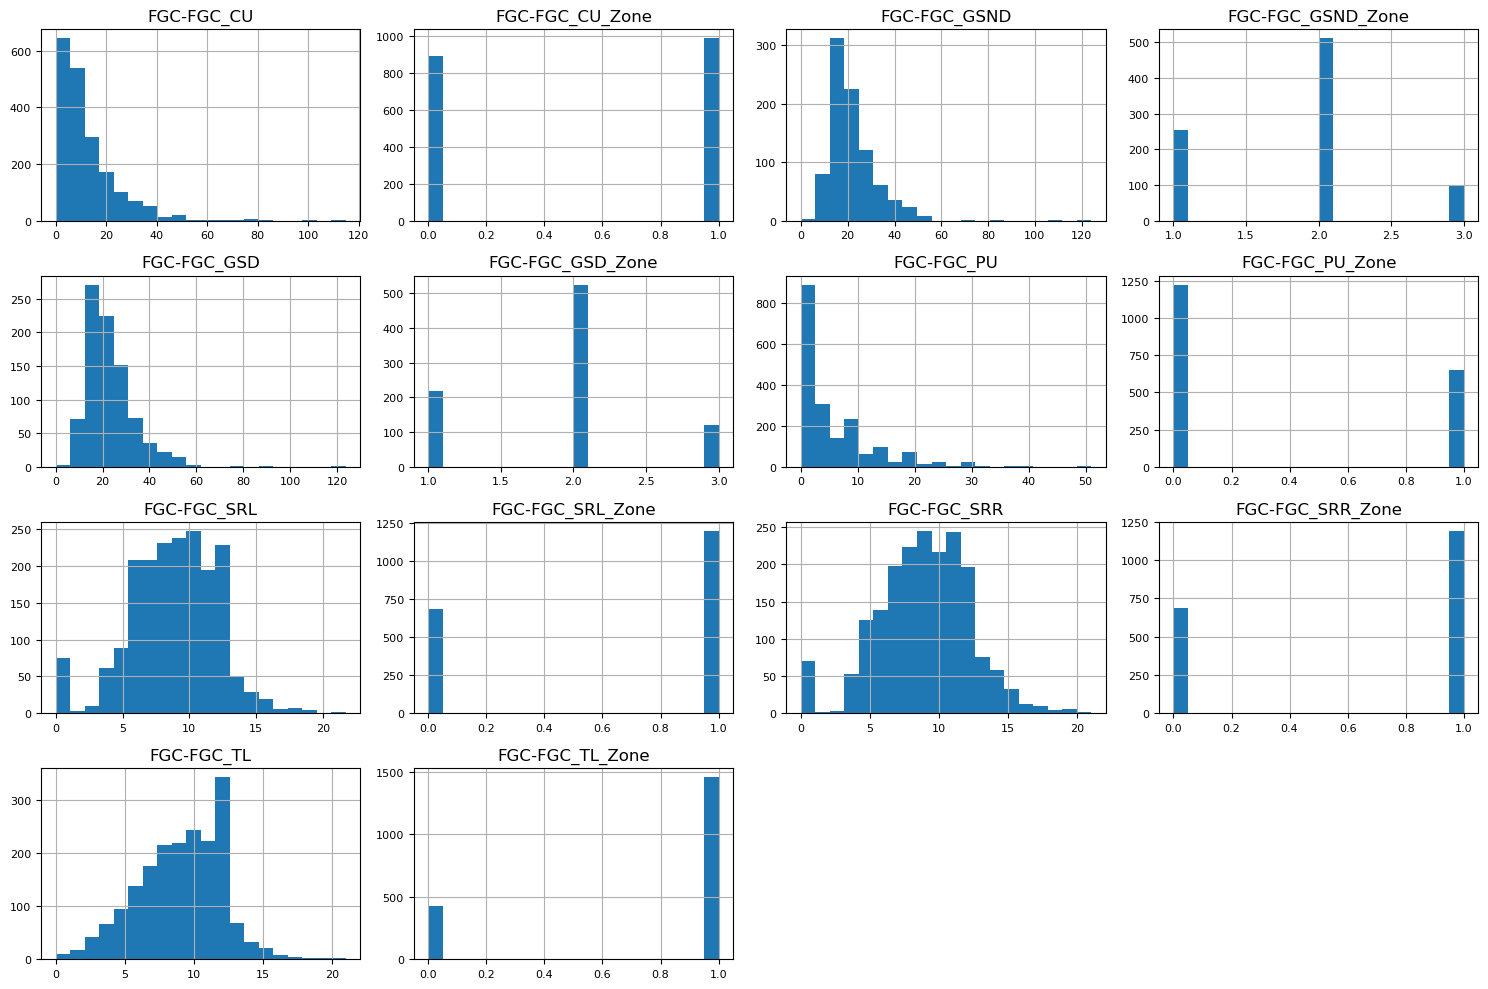

In [355]:
full_removed[FGC_cols].hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

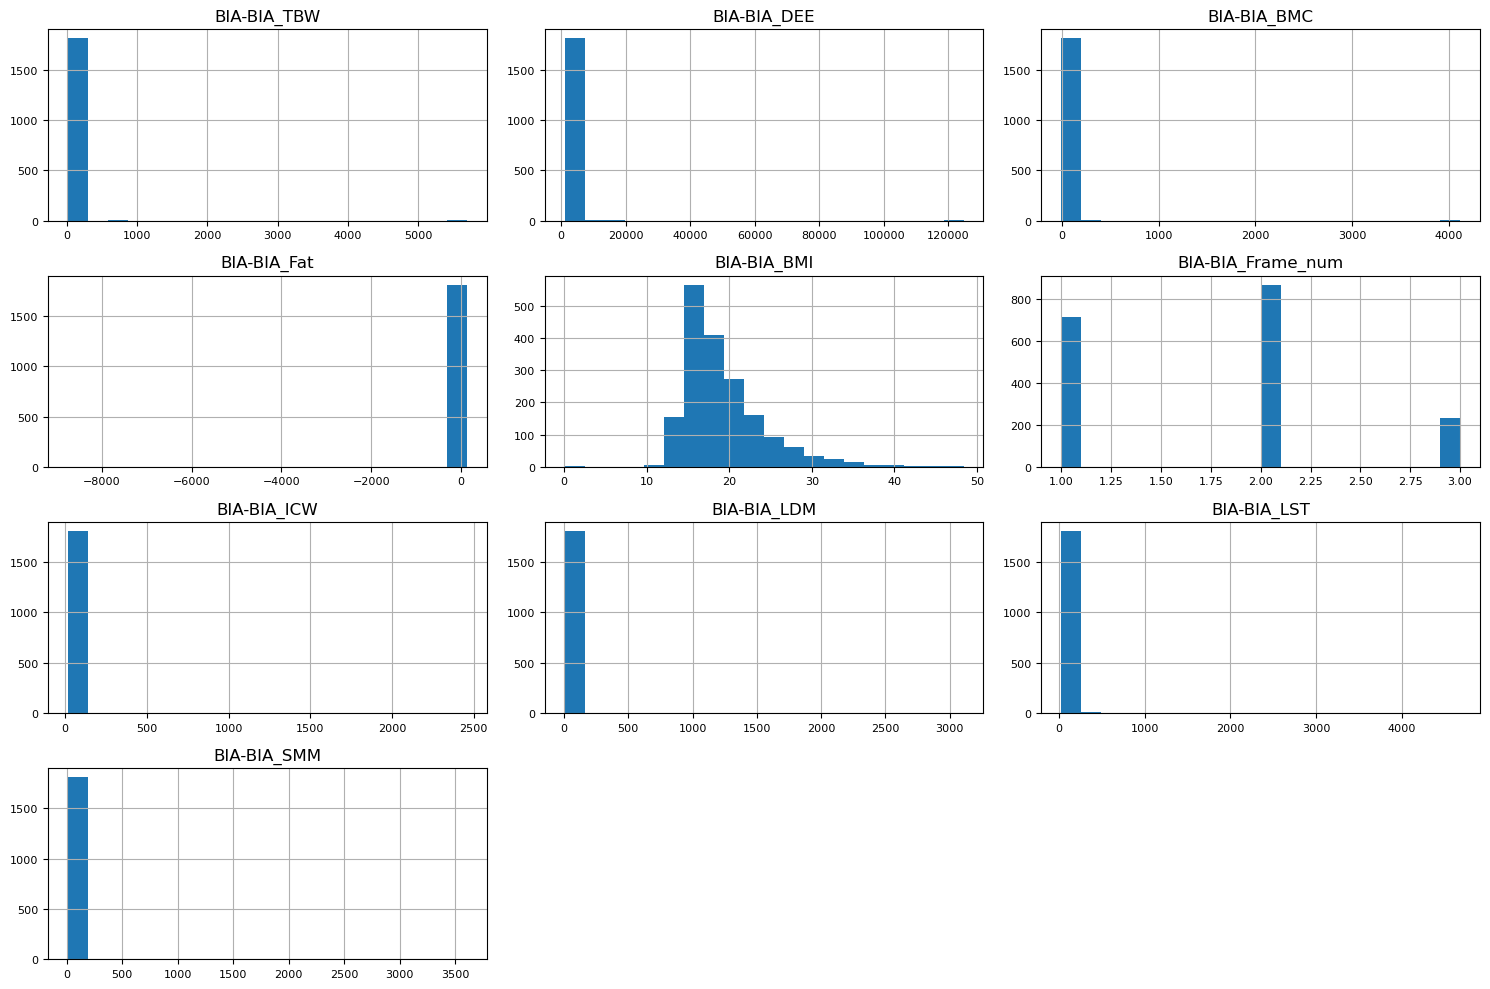

In [371]:
BIA_cols = ["BIA-BIA_TBW","BIA-BIA_DEE","BIA-BIA_BMC","BIA-BIA_Fat", "BIA-BIA_BMI",'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM']

full_removed[BIA_cols].hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

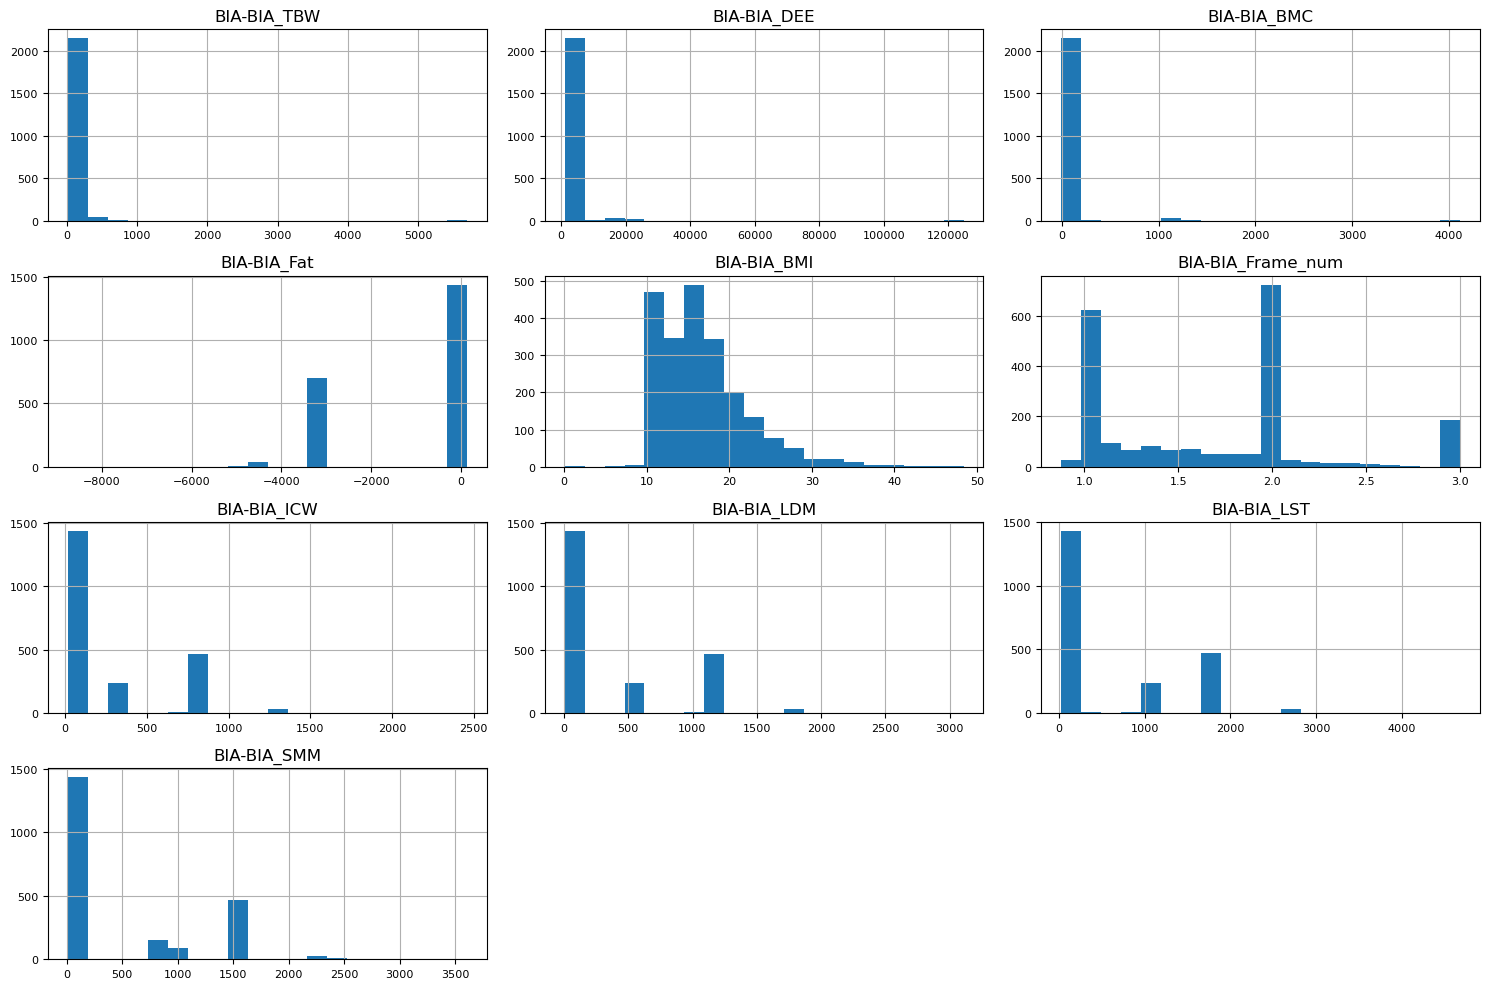

In [373]:
BIA_cols = ["BIA-BIA_TBW","BIA-BIA_DEE","BIA-BIA_BMC","BIA-BIA_Fat", "BIA-BIA_BMI",'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM']
train[BIA_cols].hist(figsize=(15, 10), bins=20, xlabelsize=8, ylabelsize=8)

plt.tight_layout()
plt.show()

In [296]:
# interation imputation

def create_interaction_features(df, feature_pairs):
    global cat_c
    for feature1, feature2 in feature_pairs:
        if(feature1 not in cat_c or feature2 not in cat_c):
            print("feature1:" + feature1 + ",feature2:" + feature2)
            new_feature_name = f"{feature1}_x_{feature2}"
            df[new_feature_name] = df[feature1] * df[feature2]
    return df

def create_chufa_features(df, feature_pairs):
    global cat_c
    for feature1, feature2 in feature_pairs:
        if feature1 not in cat_c or feature2 not in cat_c:
            print(f"feature1: {feature1}, feature2: {feature2}")
            
            # 构造 A/B 特征，先进行除法运算，但在除法之前控制出现0或NaN的情况
            new_feature_name1 = f"{feature1}_div_{feature2}"
            df[new_feature_name1] = df[feature1] / df[feature2]
            
            # 当A或B中有0或NaN时保留NaN
            df[new_feature_name1] = df[new_feature_name1].mask((df[feature1] == 0) | (df[feature2] == 0) | 
                                                               df[feature1].isna() | df[feature2].isna())
            
            # 构造 B/A 特征，类似方式处理
            new_feature_name2 = f"{feature2}_div_{feature1}"
            df[new_feature_name2] = df[feature2] / df[feature1]
            df[new_feature_name2] = df[new_feature_name2].mask((df[feature1] == 0) | (df[feature2] == 0) | 
                                                               df[feature1].isna() | df[feature2].isna())

    return df

In [297]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']
    test_data = test_data.drop(['sii'], axis=1)
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_id,
        'sii': tpTuned
    })


    return submission, tKappa

In [298]:
best_params_lgbm = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01
}

In [299]:
train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance_Time,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_PAQ_Total,PAQ_C-Season,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total
0,0,19,1,0,55.000000,0,30.795216,61.00000,163.000000,37.644036,78.000000,84,121.000000,0,5,NaN,0,7.901059,0,15.754229,1,18.740337,1,1.735646,-0.008845,5.133683,0,5.307612,0,8.071941,0,0,2.0,4.880390,30.798600,1439.190,2158.790000,34.77900,95.5561,18.0552,12.74340,67.443900,2.000000,37.700700,23.076400,90.675700,44.769000,72.479700,0,1.819184,0,0,53.665901,74.993778,0,3.00000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8,1,1,71.000000,1,17.256269,50.50000,62.600000,25.272548,76.000000,73,111.000000,1,5,530.0,1,2.000000,0,20.413850,1,19.823813,1,0.000000,0.000000,13.500000,1,14.000000,1,9.000000,1,1,3.0,11.309800,17.258200,1003.940,1606.300000,12.77070,49.1957,13.5627,3.69541,13.404300,2.000000,21.643400,14.781600,37.886000,19.520800,34.414200,0,2.089100,0,1,27.000000,40.000000,1,0.21414,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,8,1,0,70.000000,2,14.403180,52.00000,55.400000,22.179047,77.000000,89,114.000000,0,5,NaN,2,15.000000,1,16.485225,1,15.433275,1,7.000000,1.000000,11.000000,1,13.000000,1,10.000000,1,2,3.0,2.663280,14.404800,1011.340,1618.140000,11.18040,49.9839,12.9965,1.40826,5.416090,2.000000,21.565800,17.237700,47.320600,23.164100,32.746200,0,2.370000,1,2,53.000000,73.000000,1,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,8,0,2,61.000000,1,14.706858,48.00000,48.200000,22.867685,78.000000,91,111.000000,1,6,600.0,1,7.000000,1,17.999789,1,18.304092,1,3.000000,0.000000,11.000000,1,11.000000,1,4.000000,0,1,4.0,13.539600,14.708500,948.830,1992.540000,4.96490,43.3258,13.2211,1.48737,4.874160,2.000000,21.144800,17.216100,29.786300,18.518800,26.109700,0,2.465957,0,1,32.000000,46.000000,2,2.00000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,9,0,3,65.597766,3,16.039530,49.87781,29.751736,20.866233,57.648469,76,106.706013,0,8,NaN,3,4.921825,0,14.676453,1,15.617670,1,8.718650,0.975869,4.755004,0,6.132610,0,9.833665,0,3,NaN,13.449351,10.695422,NaN,1836.619284,NaN,NaN,NaN,NaN,-3123.322995,1.123323,818.226244,1120.632796,1752.005133,1457.275377,40.058759,0,2.447426,0,3,43.000000,60.000000,2,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [375]:
from sklearn.preprocessing import LabelEncoder

# Function to preprocess data for LightGBM
def preprocess_data(df):
    # Identify non-numeric columns
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    
    # Apply label encoding to non-numeric columns
    label_encoders = {}
    for col in non_numeric_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    return df, label_encoders

...
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance_Time',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_PAQ_Total', 'PAQ_C-Season',
       'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday','sii']

train = train[featuresCols]
test = test[featuresCols]
...

# Apply preprocessing to both train and test data
train_preprocessed, train_encoders = preprocess_data(train)
test_preprocessed, _ = preprocess_data(test)


Light = lgb.LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
Submission_LGBM, k_lgbm = TrainML(Light, test_preprocessed)

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

Mean Train QWK --> 0.6197
Mean Validation QWK ---> 0.4048
----> || Optimized QWK SCORE ::  0.466


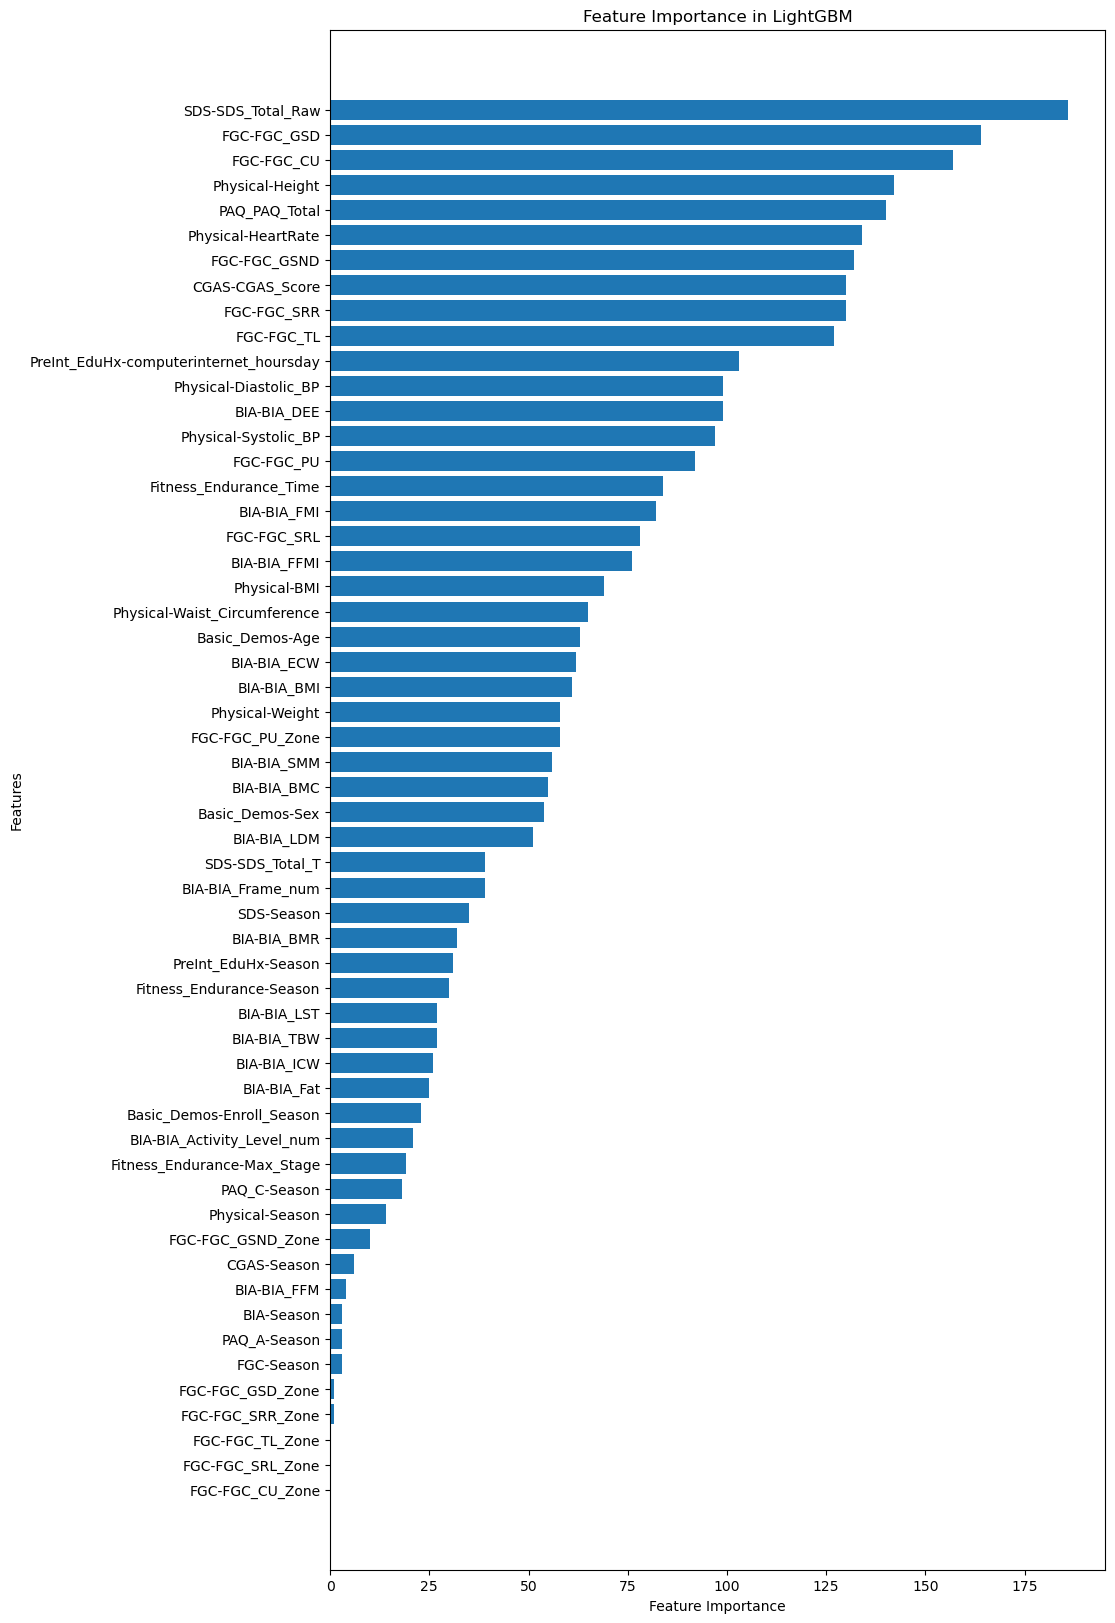

In [377]:
X = train.drop(['sii'], axis=1)
y = train['sii']

LGBM = lgb.LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
LGBM.fit(X, y)


importance = LGBM.feature_importances_


features = X.columns


importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in LightGBM')
plt.gca().invert_yaxis() 
plt.show()

In [341]:
best_params_xgb = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'reg_alpha': 1,
    'reg_lambda': 5
}
best_params_catboost = {
    'iterations': 804,
    'learning_rate': 0.007849710402582562, 
    'l2_leaf_reg': 7.31183636902306, 
    'subsample': 0.5630297785016092, 
    'random_strength': 1.7097065892440113, 
    'bagging_temperature': 0.026593521316435192,
    'border_count': 12
}

In [343]:
XGBoost = xgb.XGBRegressor(**best_params_xgb, random_state=SEED,enable_categorical=True)
Submission_XGB, k_xgb = TrainML(XGBoost, test)

Training Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

Mean Train QWK --> 0.9134
Mean Validation QWK ---> 0.4025
----> || Optimized QWK SCORE ::  0.451


In [325]:
CatBoost = CatBoostRegressor(**best_params_catboost, random_state=SEED, verbose=0,cat_features=cat_c)
Submission_CatBoost , k_cat= TrainML(CatBoost, test)

Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

Mean Train QWK --> 0.5069
Mean Validation QWK ---> 0.3789
----> || Optimized QWK SCORE ::  0.459


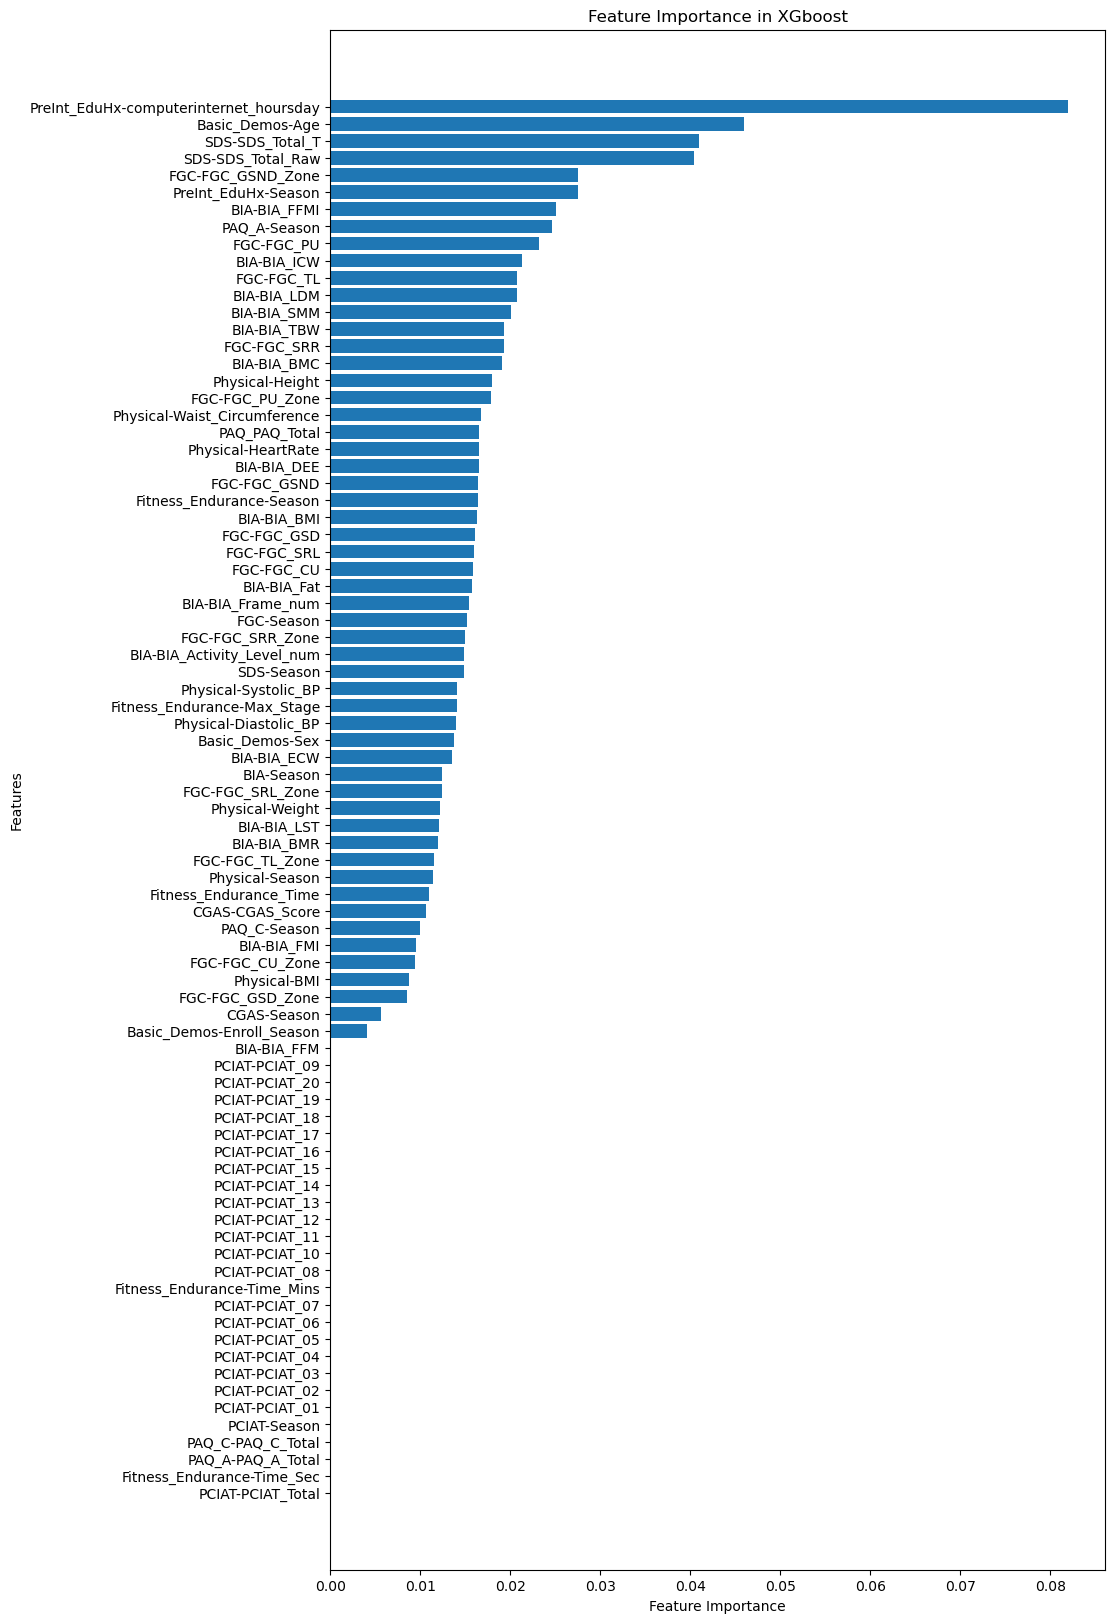

In [329]:
X = train.drop(['sii'], axis=1)
y = train['sii']

LGBM = xgb.XGBRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
LGBM.fit(X, y)


importance = LGBM.feature_importances_


features = X.columns


importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in XGboost')
plt.gca().invert_yaxis() 
plt.show()

In [ ]:
full_removed = full.dropna(subset=['sii'])

